In [1]:
!pip install cleverhans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 6.2 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
BATCH_SIZE = 1

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
testset = datasets.CIFAR10(root="~/data",
                           train=False,
                           transform=transform,
                           download=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

# Truncated testset with 1000 test images (shuffled)

truncated_testset, _ = torch.utils.data.random_split(testset, 
                                                     [1000, 9000],
                                                     generator=torch.Generator().manual_seed(0))

truncated_testloader = torch.utils.data.DataLoader(truncated_testset,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 36936812.77it/s]


Extracting /root/data/cifar-10-python.tar.gz to /root/data


Loading the trained model

In [5]:
PATH = "/content/RESNET_CLASSIFIER_L.pth"
resnet = torch.load(PATH)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Projected gradient descent attack method with early stopping functionality

In [6]:
def pgd_with_early_stopping(model, inputs, labels, eps, number_of_iters, epsilon_iters, norm):

  label_flipped = False
  
  for i in range(number_of_iters):

    adv_inputs = projected_gradient_descent(model,
                                            inputs,
                                            eps=eps,
                                            eps_iter=epsilon_iters,
                                            nb_iter=1,
                                            norm=norm,
                                            rand_init=False,
                                            sanity_checks=False)
    

    outputs = resnet(adv_inputs)

    _, predicted = torch.max(outputs.data, 1)

    label_flipped = bool(predicted!=labels)

    if label_flipped:
      print(f"Iterations for successful attack: {i}")
      break
    inputs = adv_inputs.clone()
  return adv_inputs

Clearing of CUDA Memory for efficient computation

In [19]:
torch.cuda.empty_cache()

Defining required parameters for attack

In [20]:
epsilon = 1e-4
eps_iter = 1e-5
nb = 20
norm = np.inf

Calculating adversarial distance including misclassified inputs

In [21]:
l1_distances_list = []
misclassified_distance, misclassified_idx = [], []
count = 0

for i, data in enumerate(truncated_testloader):
  inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)

  
  outputs = resnet(inputs)
  _, predicted = torch.max(outputs.data, 1)
  
  adv_inputs = pgd_with_early_stopping(resnet, inputs, labels, epsilon, nb, eps_iter, norm)

  l1_distance = torch.norm((inputs-adv_inputs), p=1)/255.0
  l1_distances_list.append(l1_distance)

  if (predicted!=labels):
    misclassified_distance.append(l1_distance)
    misclassified_idx.append(i)

  if i%100 == 0:
    print(f"Completed: {i}, l1_distance: {l1_distance}")

mean_l1_distance_1 = sum(l1_distances_list)/len(l1_distances_list)
print(mean_l1_distance_1.item())

Iterations for successful attack: 5
Completed: 0, l1_distance: 0.029246650636196136
Iterations for successful attack: 5
Iterations for successful attack: 0
Iterations for successful attack: 1
Iterations for successful attack: 9
Iterations for successful attack: 1
Iterations for successful attack: 1
Iterations for successful attack: 0
Iterations for successful attack: 5
Iterations for successful attack: 14
Iterations for successful attack: 0
Iterations for successful attack: 3
Iterations for successful attack: 11
Iterations for successful attack: 2
Iterations for successful attack: 2
Iterations for successful attack: 4
Iterations for successful attack: 5
Iterations for successful attack: 3
Iterations for successful attack: 3
Iterations for successful attack: 0
Iterations for successful attack: 0
Iterations for successful attack: 4
Iterations for successful attack: 3
Iterations for successful attack: 0
Iterations for successful attack: 3
Iterations for successful attack: 0
Iterations for

Mean value of misclassified input distances (after attack)

In [22]:
mean_misclassified_distance = sum(misclassified_distance)/len(misclassified_distance)
print(mean_misclassified_distance.item())
torch.cuda.empty_cache()

0.004496623761951923


Conversion of input_metric to its numpy type for plotting

In [23]:
def conv(input_metric):
  input_metric_tensor = torch.tensor(input_metric)
  input_metric_np = input_metric_tensor.cpu().numpy()
  return input_metric_np

Visualization

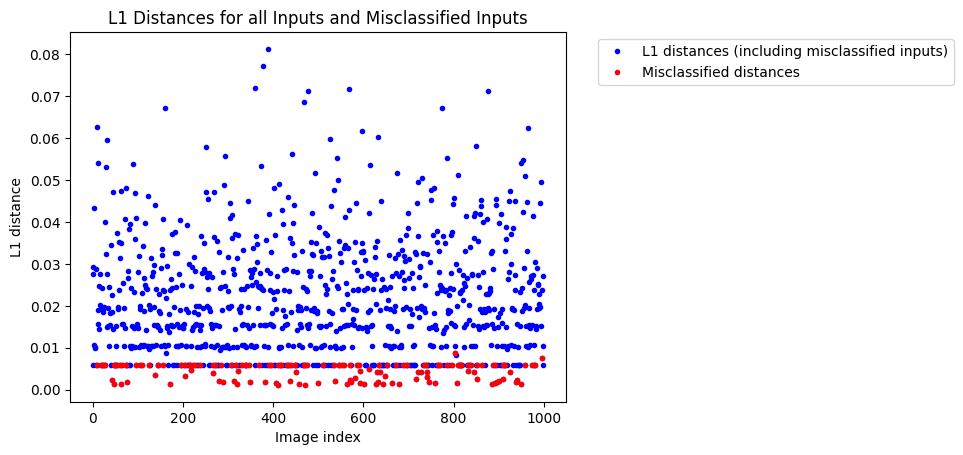

In [24]:
# Calculate L1 distances and misclassified distances
l1_distances_list_np = conv(l1_distances_list,)
misclassified_distance_np = conv(misclassified_distance,)

nb_images = np.arange(0, 1000)

# Plot both L1 distances and misclassified distances on the same plot
plt.plot(nb_images, l1_distances_list_np, ".", label="L1 distances (including misclassified inputs)", color="blue")
plt.plot(misclassified_idx, misclassified_distance_np, ".", label="Misclassified distances", color="red")

# Add labels and legend
plt.xlabel("Image index")
plt.ylabel("L1 distance")

# Move the legend outside the plot area to avoid covering the plot points
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))

# Add a title
plt.title("L1 Distances for all Inputs and Misclassified Inputs")

# Display the plot
plt.show()